In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

store = pd.HDFStore('/Users/jiaqizhang/Documents/innovation_day/stock/data/base_store.h5')
base = store['base'] 

base_f = base[base.closed_diff.notnull()]
base_f = base_f[base_f.issue_date.notnull()]
base_f = base_f[base_f.eqy_belongto_parcomsh.notnull() & (base_f.eqy_belongto_parcomsh > 0.0)]
base_f = base_f[base_f.np_belongto_parcomsh.notnull() & (base_f.np_belongto_parcomsh > 0.0) ]
base_f = base_f.fillna(0)


In [2]:
# Calculate PE/PB/PS
base_f['pe'] = base_f['mkt_cap'] / base_f['np_belongto_parcomsh']
base_f['pb'] = base_f['mkt_cap'] / base_f['eqy_belongto_parcomsh']
base_3 = base_f[base_f.weekday == 3]
#base_3 = base_f

dev = base_3[base_3.transaction_date >= pd.to_datetime('2012-01-01')]
dev = dev[dev.transaction_date < pd.to_datetime('2015-01-01')]

val = base_3[base_3.transaction_date < pd.to_datetime('2013-01-01')]
oot = base_3[base_3.transaction_date >= pd.to_datetime('2015-01-01')]

meta_variables = ['adjfactor', 'code', 'transaction_date', 'ipo_date', 'out_date', 'close_7d', 'open_7d', 'closed_diff', 'issue_date']
all_vars = base_f.columns
key_vars = ['code', 'transaction_date']
target_var = ['closed_diff']
candidate_vars = [var for var in all_vars if var not in meta_variables]


candidate_vars = ['swing','days_since_ipo','turn','vol','amount','low','high','open','close','pb','mkt_cap','pe']

dev_x = dev[candidate_vars]
dev_y = dev[target_var].as_matrix().flatten() * -1.0
dev_y = [1 if var > 0.03 else 0 for var in dev_y]

val_x = val[candidate_vars]
val_y = val[target_var].as_matrix().flatten() * -1.0
val_y = [1 if var > 0.03 else 0 for var in val_y]

oot_x = oot[candidate_vars]
oot_y = oot[target_var].as_matrix().flatten() * -1.0
oot_y = [1 if var > 0.03 else 0 for var in oot_y]


# Normalization
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(dev_x)
dev_n_x = scaler.transform(dev_x)
val_n_x = scaler.transform(val_x)
oot_n_x = scaler.transform(oot_x)

# Random Forest Model
- assume all the new onboarded stock is easy to buy

In [3]:
from sklearn.ensemble import ExtraTreesClassifier 

clf = ExtraTreesClassifier(n_estimators=100, max_features = len(candidate_vars))

clf.fit(dev_n_x, dev_y)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features=12, max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [4]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(dev_n_x.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, dev_x.columns[indices[f]], importances[indices[f]]))

pred_y = clf.predict_proba(dev_n_x)
dev_scores = pd.DataFrame(pred_y)
dev_scores['tag'] = pd.Series(dev_y)

pred_y = clf.predict_proba(val_n_x)
val_scores = pd.DataFrame(pred_y)
val_scores['tag'] = pd.Series(val_y)

pred_y = clf.predict_proba(oot_n_x)
oot_scores = pd.DataFrame(pred_y)
oot_scores['tag'] = pd.Series(oot_y)

from sklearn.metrics import roc_curve, auc

dev_fpr, dev_tpr, _ = roc_curve(dev_scores['tag'], dev_scores[1], pos_label = 1)
dev_auc = auc(dev_fpr, dev_tpr)

val_fpr, val_tpr, _ = roc_curve(val_scores['tag'], val_scores[1], pos_label = 1)
val_auc = auc(val_fpr, val_tpr)

oot_fpr, oot_tpr, _ = roc_curve(oot_scores['tag'], oot_scores[1], pos_label = 1)
oot_auc = auc(oot_fpr, oot_tpr)

print ("dev auc: %d; val auc: %d; oot aud: %d", dev_auc, val_auc, oot_auc)

Feature ranking:
1. feature swing (0.108385)
2. feature days_since_ipo (0.104766)
3. feature turn (0.093232)
4. feature pb (0.089645)
5. feature pe (0.088542)
6. feature vol (0.087888)
7. feature mkt_cap (0.085945)
8. feature amount (0.085809)
9. feature open (0.066106)
10. feature close (0.065167)
11. feature low (0.062467)
12. feature high (0.062048)
('dev auc: %d; val auc: %d; oot aud: %d', 1.0, 0.93354093910080427, 0.52641557799906646)


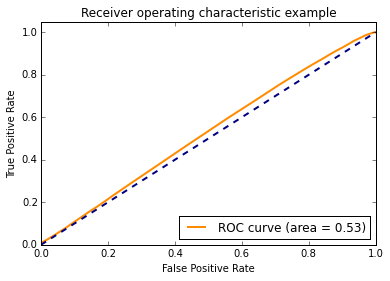

In [5]:
plt.figure()
lw = 2
plt.plot(oot_fpr, oot_tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % oot_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [6]:
oot_re = oot.reset_index()
oot_re['predict'] = oot_scores[1]
oot_re['tag'] = oot_scores['tag']

oot_re['gain'] = (oot_re['close_7d'] - oot_re['close']) / oot_re['close']

keep_vars = ['code', 'transaction_date', 'close', 'close_7d', 'predict', 'tag',
            'swing',
'days_since_ipo',
'turn',
'vol',
'amount',
'low',
'high',
'open',
'pb',
'mkt_cap',
'pe', 'gain'] 

oot_re = oot_re[keep_vars]


In [13]:
oot_gain = oot_re[oot_re.predict > 0.7 ]
oot_gain = oot_gain[oot_gain.transaction_date > pd.to_datetime('2016-01-01')]
oot_gain = oot_gain[['transaction_date', 'gain', 'days_since_ipo']]

gain_summary= oot_gain.groupby('transaction_date').mean()

gain_summary.gain.describe()

count    36.000000
mean      0.275363
std       0.168896
min      -0.047641
25%       0.166584
50%       0.246932
75%       0.417515
max       0.610815
Name: gain, dtype: float64

In [15]:
oot_gain = oot_re[oot_re.predict > 0.7 ]
oot_gain = oot_gain[oot_gain.transaction_date > pd.to_datetime('2016-01-01')]
oot_gain = oot_gain.reset_index()

oot_gain = oot_gain.sort(['transaction_date', 'days_since_ipo'], ascending=[1, 0])
oot_gain[['transaction_date', 'days_since_ipo', 'gain', 'code', 'tag', 'predict', 'close', 'close_7d']]



/Users/jiaqizhang/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,transaction_date,days_since_ipo,gain,code,tag,predict,close,close_7d
0,2016-01-07,9109.0,0.000000,000002.sz,0,0.72,23.45,23.45
14,2016-01-07,7944.0,0.000000,000035.sz,0,0.79,7.67,7.67
48,2016-01-07,6414.0,0.000000,600153.sh,0,0.75,17.17,17.17
23,2016-01-07,3431.0,-0.079929,002062.sz,0,0.72,5.63,5.18
27,2016-01-07,2218.0,-0.088127,002319.sz,0,0.71,16.34,14.90
30,2016-01-07,1997.0,-0.095455,002452.sz,0,0.76,11.00,9.95
42,2016-01-07,1595.0,-0.037855,300258.sz,0,0.80,9.51,9.15
33,2016-01-07,1526.0,-0.110713,002627.sz,0,0.71,22.31,19.84
159,2016-01-07,289.0,0.000000,300431.sz,0,0.72,95.83,95.83
113,2016-01-07,16.0,0.610932,002782.sz,1,0.86,12.44,20.04


In [16]:
oot_gain = oot_re[(oot_re.predict > 0.7) & (oot_re.days_since_ipo > 180) ]
oot_gain = oot_gain[oot_gain.transaction_date > pd.to_datetime('2016-01-01')]
oot_gain = oot_gain[['transaction_date', 'gain', 'days_since_ipo']]

gain_summary= oot_gain.groupby('transaction_date').mean()

gain_summary.gain.describe()

count    35.000000
mean      0.026552
std       0.062211
min      -0.055502
25%      -0.000066
50%       0.001782
75%       0.034613
max       0.226800
Name: gain, dtype: float64

# Conclusion
- it is not easy to buy new stocks